# **Section0502_Group04_Project**

  

---



### Introduction

In this project, we aim to apply technical trading strategies to construct an optimized portfolio with a Sharpe ratio greater than 1.0. By analyzing historical price data from various asset classes, we will utilize moving averages, Bollinger Bands, and other portfolio optimization techniques to identify the best-performing strategies. Our approach is driven by the goal of achieving a diversified portfolio that maximizes returns while minimizing risk, as reflected in the portfolio's Sharpe ratio.

### Our Choices:

In [22]:
# For grading.
maFast = 11
maSlow = 220
bbWindow = 23
bbStdevBand = 2
myStrategies = [
    'AAPL-MAFlat', 'AMZN-MAFlat', 'EUR-MAShort',
    'FBNDX-MAShort', 'GE-MAShort', 'GOLD-MAFlat',
    'INTC-BB', 'SPY-MAFlat'
]

### Importing Required Libraraies:

In [23]:
# import necessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

### Defining all the required functions:

In [24]:
def read_price_data(filename, index_col=0, parse_dates=True):
    # Reading the CSV file
    df = pd.read_csv(filename, index_col=index_col, parse_dates=parse_dates)

    # Printing dataframe information
    print("Dataframe info:")
    print(df.info())

    # Checking for any null values
    print("\nChecking for any null values:")
    print(df.isnull().sum())

    # Printing summary statistics
    print("\nSummary statistics:")
    print(df.describe())

    # Displaying the dataframe
    print("\nDisplaying dataFrame:")
    print(df)
    return df

In [25]:
def plot_and_format_y_axis(data_frame, formatter=ticker.ScalarFormatter(useOffset=False), aspect_ratio=(12, 8), title='', ylabel='', label='', grid=True):

    # Setting figure size and plotting data
    fig = data_frame.plot(figsize=aspect_ratio, grid=grid)

    # Setting the title and y-axis label
    fig.set_title(title)
    fig.set_ylabel(ylabel)

    # Applying the formatter to the y-axis
    fig.yaxis.set_major_formatter(formatter)
    if isinstance(formatter, ticker.PercentFormatter):
        formatter.decimals = 0


    # Displaying the plot
    plt.show()

In [26]:
def print_pct_data(data_frame, stringFmtSpec='{:.4%}', na_rep='NaN', index_slice=None):
    if index_slice is not None:
        styler = data_frame.style.format(na_rep=na_rep)
        styler = styler.format(stringFmtSpec, subset=pd.IndexSlice[index_slice, :])
    else:
        styler = data_frame.style.format(stringFmtSpec, na_rep=na_rep)

    return styler

In [27]:
def calcPerformanceStatistics(returns, annualization_factor=260, print_Screen=True, percent_format_string='{:.2%}'):
    if pd.isna(returns.iloc[0, 0]):  # Check if the first value is NaN
        if not returns.iloc[0].isna().all():  # Check if all values in the first row are NaN
            raise ValueError("First row should be all NaN or not NaN at all.")
    else:
        returns = pd.concat([pd.DataFrame(index=[returns.index[0] - pd.Timedelta(days=1)], columns=returns.columns), returns])

    # assign the cumulative returns to a new variable which will have the first NaN row
    cumReturns = returns.cumsum()
    # verify replace the NaN row with zeroes
    cumReturns = cumReturns.fillna(0)
    # Calculate High Water Mark (HWM)
    high_water_mark = np.maximum.accumulate(cumReturns)
    underWaterCurve = cumReturns - high_water_mark

    average_annual_return = annualization_factor * returns.mean()
    annual_risk = np.sqrt(annualization_factor) * returns.std()
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(annualization_factor)
    max_drawdown = underWaterCurve.min()
    success_ratio = (returns.dropna() >= 0).sum() / returns.dropna().shape[0]


    summary_stats = pd.DataFrame([
        average_annual_return,
        annual_risk,
        sharpe_ratio,
        max_drawdown,
        success_ratio
    ], index=['Average Annual Return', 'Annual Risk', 'Sharpe Ratio', 'Max Drawdown', 'Success Ratio'])

    if print_Screen:
        print("Performance Statistics:")
        print_pct_data(summary_stats, percent_format_string)

    return summary_stats

In [28]:
def movingAverageCrossover(prices, fastWindow, slowWindow):
    prices = prices.copy()
    if prices.shape[1] > 1:
        raise ValueError("Input dataFrame should have only one column.")

    # Calculate moving averages
    prices.loc[:,"FastSMA"] = prices[f"{prices.columns[0]}"].rolling(window=fastWindow).mean()
    prices.loc[:,"SlowSMA"] = prices[f"{prices.columns[0]}"].rolling(window=slowWindow).mean()
    prices.dropna(inplace=True)

    # Benchmark (Buy and Hold)
    prices.loc[:,f"{prices.columns[0]}-BMK-MA"] = np.log(prices[f"{prices.columns[0]}"] / prices[f"{prices.columns[0]}"].shift(1))

    # "Go Flat" strategy (flat when fast MA is below slow MA)
    prices.loc[:,'PositionFlat'] = np.where(prices['FastSMA'] > prices['SlowSMA'], 1, 0)  # 1 if fast > slow, 0 otherwise
    prices.style.format(na_rep='NaN')
    flat_returns = prices['PositionFlat'].shift(1) * prices[f"{prices.columns[0]}-BMK-MA"]

    # "Go Short" strategy (short when fast MA is below slow MA)
    prices.loc[:,'PositionShort'] = np.where(prices['FastSMA'] > prices['SlowSMA'], 1, -1)  # 1 for long, -1 for short
    prices.style.format(na_rep='NaN')
    short_returns = prices['PositionShort'].shift(1) * prices[f"{prices.columns[0]}-BMK-MA"]

    result = pd.DataFrame({
        f"{prices.columns[0]}-BMK-MA": prices[f"{prices.columns[0]}-BMK-MA"].squeeze(),
        f"{prices.columns[0]}-MAFlat": flat_returns.squeeze(),
        f"{prices.columns[0]}-MAShort": short_returns.squeeze()
    }, index=prices.index)

    return result


In [29]:
def bollingerBands(prices, lookbackWindow, stdevBand):
    prices = prices.copy()

    if prices.shape[1] > 1:
        raise ValueError("Input dataFrame should have only one column.")

    # Calculate the moving average and standard deviation
    prices['SMA'] = prices[f"{prices.columns[0]}"].rolling(window=lookbackWindow).mean()
    prices['STD'] = prices[f"{prices.columns[0]}"].rolling(window=lookbackWindow).std()
    prices.dropna(inplace=True)

    # Calculate the upper and lower Bollinger Bands
    prices['UpperBand'] = prices['SMA'] + (stdevBand * prices['STD'])
    prices['LowerBand'] = prices['SMA'] - (stdevBand * prices['STD'])

    # Bollinger Band strategy

    # initialize the first row based on the close price vis-a-vis the bands
    # here, we're also initializng a new column called 'Position'
    date0 = prices.index[0]
    if prices.loc[date0, prices.columns[0]] >= prices.loc[date0, 'UpperBand']:
        prices.loc[date0, 'Position'] = -1
    elif prices.loc[date0, prices.columns[0]] <= prices.loc[date0, 'LowerBand']:
        prices.loc[date0, 'Position'] = 1
    else:
        prices.loc[date0, 'Position'] = 0

    # Loop over the entire data set starting from the second row
    for i in range(1, prices.shape[0]):
        today = prices.index[i]
        yesterday = prices.index[i - 1]

        # If today's price is above the upper band, go short (-1)
        if prices.loc[today, prices.columns[0]] >= prices.loc[today, 'UpperBand']:
            prices.loc[today, 'Position'] = -1

        # If today's price is below the lower band, go long (1)
        elif prices.loc[today, prices.columns[0]] <= prices.loc[today, 'LowerBand']:
            prices.loc[today, 'Position'] = 1

        # If yesterday's position was short and today's price is below the mean, flatten (0)
        elif prices.loc[yesterday, 'Position'] == -1 and prices.loc[today, prices.columns[0]] <= prices.loc[today, 'SMA']:
            prices.loc[today, 'Position'] = 0

        # If yesterday's position was long and today's price is above the mean, flatten (0)
        elif prices.loc[yesterday, 'Position'] == 1 and prices.loc[today, prices.columns[0]] >= prices.loc[today, 'SMA']:
            prices.loc[today, 'Position'] = 0

        # Otherwise, maintain yesterday's position
        else:
            prices.loc[today, 'Position'] = prices.loc[yesterday, 'Position']

    # Benchmark using log returns
    prices[f"{prices.columns[0]}-BMK-BB"] = np.log(prices[f"{prices.columns[0]}"] / prices[f"{prices.columns[0]}"].shift(1))

    # Calculate the returns for the Bollinger Band strategy
    prices[f"{prices.columns[0]}-BB"] = prices['Position'].shift(1) * prices[f"{prices.columns[0]}-BMK-BB"]

    # Drop NaN values that were introduced during calculations
    prices.dropna(inplace=True)

    result = pd.DataFrame({
        f"{prices.columns[0]}-BMK-BB": prices[f"{prices.columns[0]}-BMK-BB"],
        f"{prices.columns[0]}-BB": prices[f"{prices.columns[0]}-BB"]
    }, index=prices.index)

    return result


## Q1.  Implementing Moving Average Crossover and Bollinger Bands (Creating the runMovingAverageAndBB Function)

In [30]:
import pandas as pd

def runMovingAverageAndBB(dataFrame, fastWindow, slowWindow, bbWindow, stdevBand):

    # Run the movingAverageCrossover function
    ma_result = movingAverageCrossover(dataFrame.copy(), fastWindow, slowWindow)

    # Run the bollingerBands function
    bb_result = bollingerBands(dataFrame.copy(), bbWindow, stdevBand)

    # Perform an inner join on the index (date)
    result = ma_result.join(bb_result, how='inner').dropna()

    # Ensure that the columns for BMK-MA and BMK-BB are identical
    bmk_ma_col = [col for col in result.columns if 'BMK-MA' in col][0]
    bmk_bb_col = [col for col in result.columns if 'BMK-BB' in col][0]

    if not result[bmk_ma_col].equals(result[bmk_bb_col]):
        raise ValueError("BMK-MA and BMK-BB columns should be identical.")

    # Return the joined DataFrame with 5 columns
    return result


## Q2. Importing Close Price Data for Multiple Asset Classes

In [31]:
# Importing Prices csv file.
dfPrices = pd.read_csv('PricesProjectA.csv', index_col=0, parse_dates=True)

In [32]:
dfPrices

AAPL       AMZN        ATT     AUD     EUR  FBNDX  \
1999-12-31   0.917969   3.806250  36.820244  0.6567  1.0062   6.89   
2000-01-03   0.999442   4.468750  35.498489  0.6585  1.0243   6.85   
2000-01-04   0.915179   4.096875  33.421452  0.6550  1.0296   6.87   
2000-01-05   0.928571   3.487500  33.940708  0.6579  1.0321   6.84   
2000-01-06   0.848214   3.278125  33.043808  0.6533  1.0328   6.86   
...               ...        ...        ...     ...     ...    ...   
2018-12-24  36.707500  67.197998  20.664654  0.7049  1.1406   7.68   
2018-12-26  39.292500  73.544998  21.208460  0.7066  1.1353   7.65   
2018-12-27  39.037498  73.082001  21.261330  0.7033  1.1430   7.63   
2018-12-28  39.057499  73.901001  21.495468  0.7047  1.1444   7.66   
2018-12-31  39.435001  75.098503  21.555891  0.7049  1.1467   7.67   

                    GE     GOLD       INTC         LEHM   SILVER         SPY  
1999-12-31  396.794861   288.00  41.156250   798.154631   5.3800  146.875000  
2000-01-03  384.615387   289.00  43.500000   793.868670   5.4050  145.437500  
2000-01-04  369.230774   282.25  41.468750   796.761677   5.3250  139.750000  
2000-01-05  368.589752   280.00  41.812500   793.118215   5.1450  140.000000  
2000-01-06  373.517639   281.10  39.375000   795.091984   5.1200  137.750000  
...                ...      ...        ...          ...      ...         ...  
2018-12-24   53.230770  1269.22  43.590000   998.805410  14.7750  234.339996  
2018-12-26   56.846153  1267.14  46.189999   996.301026  15.0355  246.179993  
2018-12-27   55.923077  1275.71  46.360001   998.396182  15.2275  248.070007  
2018-12-28   57.769230  1280.71  46.750000   998.680796  15.3839  247.750000  
2018-12-31   58.230770  1282.49  46.930000  1000.995080  15.4950  249.919998  

[4745 rows x 12 columns]

## Q3. Choosing Instruments and Applying Technical Strategies for Optimal Portfolio Sharpe

In [12]:
import pandas as pd
import numpy as np

# Define the Sharpe ratio calculation function
def calculate_sharpe(returns):
    """Calculate the annualized Sharpe ratio."""
    try:
        # Calculate the mean and standard deviation
        mean_return = returns.mean()
        std_dev = returns.std()

        # Check if standard deviation is zero to avoid division by zero
        if mean_return == 0 or std_dev == 0:
            return np.nan

        # Calculate the Sharpe ratio
        sharpe_ratio = mean_return / std_dev * np.sqrt(260)
        return sharpe_ratio

    except Exception as e:
        print(f"An error occurred during Sharpe ratio calculation: {e}")
        return None

# List of instruments for analysis
instruments = ['AAPL','AMZN','GE','INTC','SPY','FBNDX','GOLD','EUR']

# Define parameter ranges for fast and slow windows
fastWindow_range = range(5, 110, 1)
slowWindow_range = range(50, 500, 1)
lookback_range = range(20, 70)
stdev_range = np.arange(1, 4, 1)

#For Testing
# fastWindow_range = range(5, 20, 5)
# slowWindow_range = range(50, 20, 5)
# lookback_range = range(2, 20)
# stdev_range = np.arange(1, 3, 1)

# Initialize a dictionary to store results for each instrument
results = {}

# Iterate through each instrument
for instrument in instruments:
    print(f"Analyzing {instrument}...")

    # Initialize lists to store Sharpe ratios and window combinations for each instrument
    go_flat_sharpe_ratios = []
    go_short_sharpe_ratios = []
    bb_sharpe_ratios = []
    window_combinations_ma = []
    window_combinations_bb = []


    bmk_df = np.log(dfPrices[[instrument]] / dfPrices[[instrument]].shift(1))
    bmk_sharpe = calculate_sharpe(bmk_df.iloc[:, 0])

    # Loop through fast and slow window combinations
    for fastWindow in fastWindow_range:
        for slowWindow in slowWindow_range:
            # Run the moving average crossover strategy for the instrument
            result = movingAverageCrossover(dfPrices[[instrument]], fastWindow, slowWindow)

            # Calculate the Sharpe ratios for both strategies using column index
            # Assuming flat_returns is at index 1 and short_returns is at index 2 in the result DataFrame
            go_flat_returns = result.iloc[:, 1]  # Access flat_returns by column number
            go_short_returns = result.iloc[:, 2]  # Access short_returns by column number

            go_flat_sharpe = calculate_sharpe(go_flat_returns.dropna())
            go_short_sharpe = calculate_sharpe(go_short_returns.dropna())

            # Store the Sharpe ratios and window combination
            go_flat_sharpe_ratios.append(go_flat_sharpe)
            go_short_sharpe_ratios.append(go_short_sharpe)
            window_combinations_ma.append((fastWindow, slowWindow))


    for lookbackWindow in lookback_range:
        for stdevBand in stdev_range:
            result_bb = bollingerBands(dfPrices[[instrument]], lookbackWindow, stdevBand)
            bb_returns = result_bb.iloc[:,1]

            bb_sharpe = calculate_sharpe(bb_returns.dropna())

            bb_sharpe_ratios.append(bb_sharpe)
            window_combinations_bb.append((lookbackWindow, stdevBand))



    # Convert to DataFrame for further analysis
    sharpe_data_ma = pd.DataFrame({
        'fastWindow': [combo[0] for combo in window_combinations_ma],
        'slowWindow': [combo[1] for combo in window_combinations_ma],
        'GoFlatSharpe': go_flat_sharpe_ratios,
        'GoShortSharpe': go_short_sharpe_ratios,
    })

    sharpe_data_bb = pd.DataFrame({
        'lookbackWindow': [combo[0] for combo in window_combinations_bb],
        'stdevBand': [combo[1] for combo in window_combinations_bb],
        'BBSharpe': bb_sharpe_ratios,
    })

    # Store the DataFrame in the results dictionary
    results[instrument] = (sharpe_data_ma, sharpe_data_bb)

    # Find the best Sharpe ratios for both strategies
    best_flat_sharpe_idx = np.nanargmax(go_flat_sharpe_ratios)
    best_short_sharpe_idx = np.nanargmax(go_short_sharpe_ratios)
    best_bb_sharpe_idx = np.nanargmax(bb_sharpe_ratios)

    best_flat_windows = window_combinations_ma[best_flat_sharpe_idx]
    best_short_windows = window_combinations_ma[best_short_sharpe_idx]
    best_bb_windows = window_combinations_bb[best_bb_sharpe_idx]

    print(f"Best Go Flat Sharpe for {instrument}: {go_flat_sharpe_ratios[best_flat_sharpe_idx]:.3f} with fastWindow={best_flat_windows[0]} and slowWindow={best_flat_windows[1]}")
    print(f"Best Go Short Sharpe for {instrument}: {go_short_sharpe_ratios[best_short_sharpe_idx]:.3f} with fastWindow={best_short_windows[0]} and slowWindow={best_short_windows[1]}")
    print(f"Best BB Sharpe for {instrument}: {bb_sharpe_ratios[best_bb_sharpe_idx]:.3f} with lookbackWindow={best_bb_windows[0]} and stdevBand={best_bb_windows[1]}")
    print(f"Best BMK Sharpe for {instrument}: {bmk_sharpe:.3f}")
    print("\n")

Analyzing AAPL...
Best Go Flat Sharpe for AAPL: 1.029 with fastWindow=5 and slowWindow=239
Best Go Short Sharpe for AAPL: 0.801 with fastWindow=5 and slowWindow=189
Best BB Sharpe for AAPL: -0.085 with lookbackWindow=26 and stdevBand=3
Best BMK Sharpe for AAPL: 0.476


Analyzing AMZN...
Best Go Flat Sharpe for AMZN: 0.808 with fastWindow=109 and slowWindow=242
Best Go Short Sharpe for AMZN: 0.584 with fastWindow=109 and slowWindow=243
Best BB Sharpe for AMZN: 0.442 with lookbackWindow=26 and stdevBand=3
Best BMK Sharpe for AMZN: 0.305


Analyzing GE...
Best Go Flat Sharpe for GE: 0.233 with fastWindow=96 and slowWindow=102
Best Go Short Sharpe for GE: 0.580 with fastWindow=96 and slowWindow=102
Best BB Sharpe for GE: 0.119 with lookbackWindow=48 and stdevBand=3
Best BMK Sharpe for GE: -0.335


Analyzing INTC...
Best Go Flat Sharpe for INTC: 0.230 with fastWindow=62 and slowWindow=216
Best Go Short Sharpe for INTC: 0.382 with fastWindow=61 and slowWindow=55
Best BB Sharpe for INTC: 0.42

### Now, we'll plot Sharpe Ratio graphs for all strategies so that we can analyze regions of parameters that could help us pick an optimal parameter for this project.

#### Plotting Go Flat Graphs

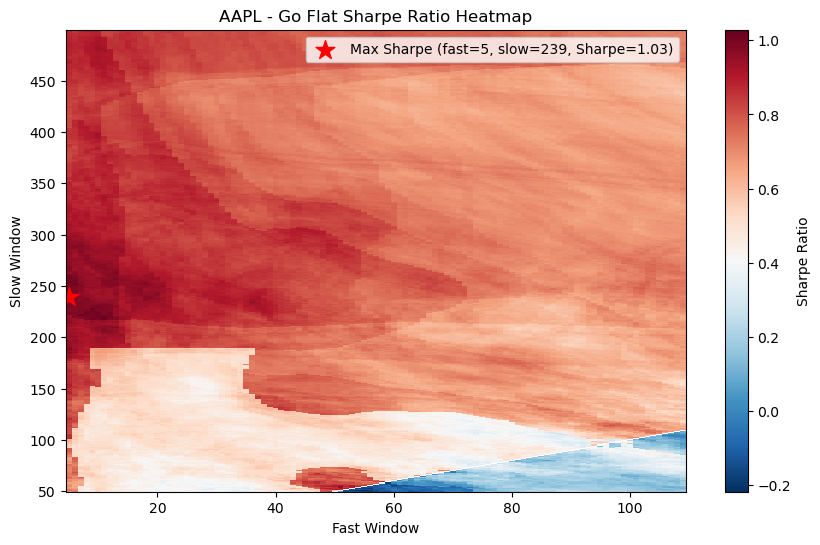

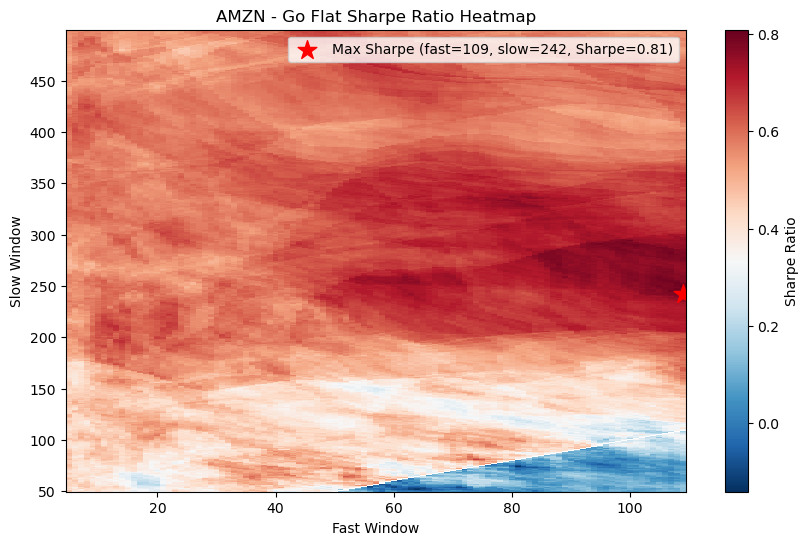

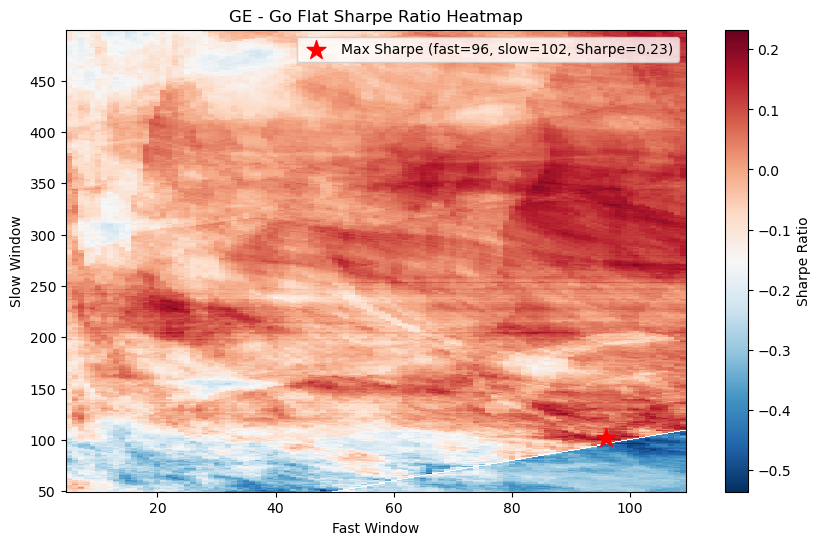

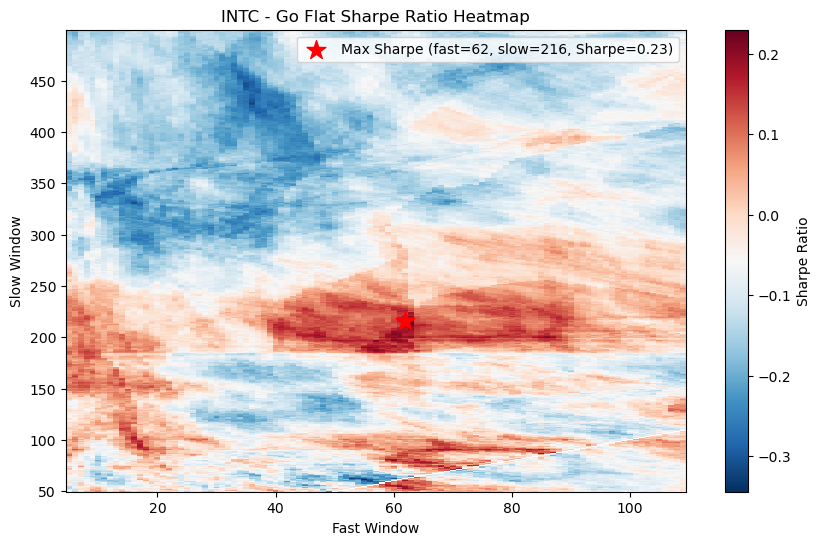

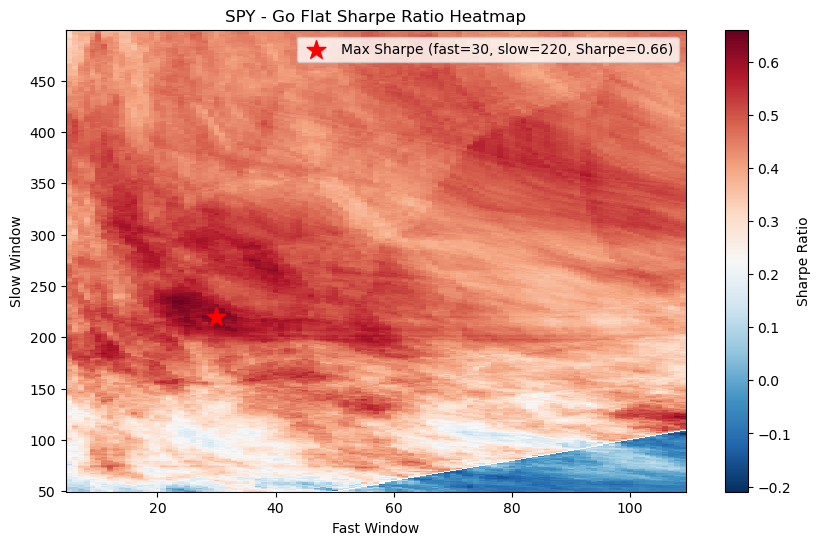

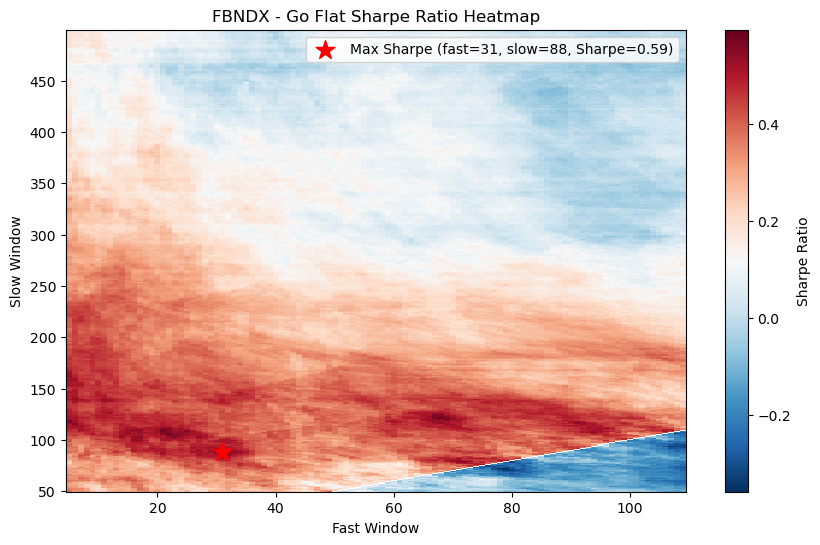

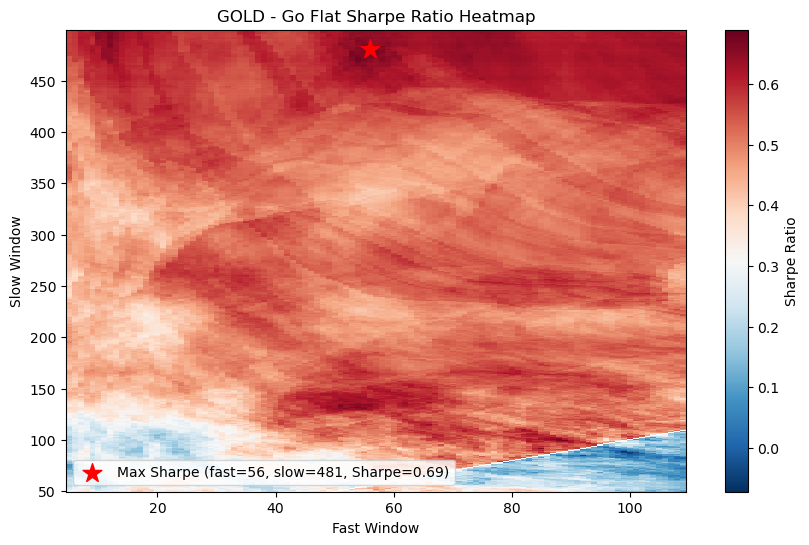

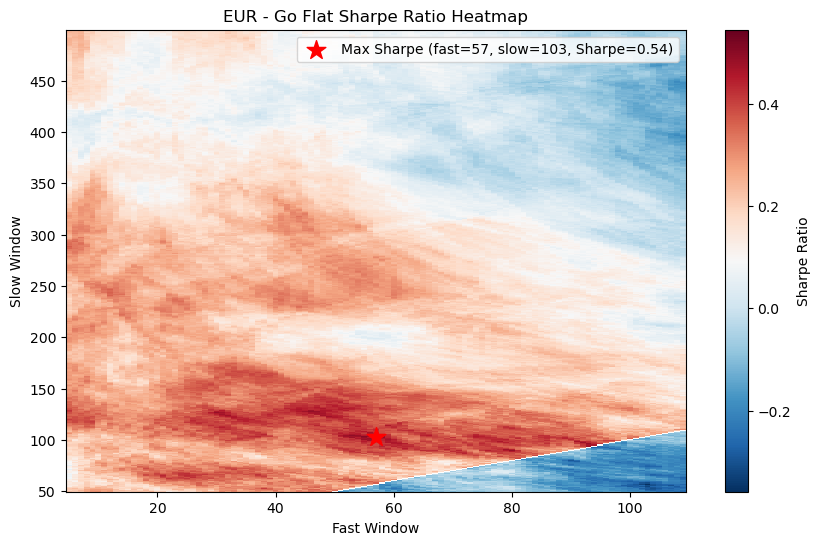

In [13]:
import matplotlib.pyplot as plt
import numpy as np
# Now plot the heatmaps for "Go Flat" strategy

# Loop through each instrument in the results dictionary to create heatmaps
for instrument, sharpe_data in results.items():
    # Extract unique fast and slow windows
    fast_windows = np.unique(sharpe_data[0]['fastWindow'])
    slow_windows = np.unique(sharpe_data[0]['slowWindow'])

    # Reshape the Go Flat Sharpe ratios into a grid for plotting
    sharpe_matrix = sharpe_data[0].pivot(index='slowWindow', columns='fastWindow', values='GoFlatSharpe').values

    # Find the best Sharpe ratio for the current instrument
    best_sharpe_idx = np.nanargmax(sharpe_matrix)  # Get the index of the max Sharpe value
    best_slow_idx, best_fast_idx = np.unravel_index(best_sharpe_idx, sharpe_matrix.shape)
    best_fast_window = fast_windows[best_fast_idx]
    best_slow_window = slow_windows[best_slow_idx]
    best_sharpe = sharpe_matrix[best_slow_idx, best_fast_idx]

    # Create the heatmap plot for the Go Flat Sharpe ratio
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(fast_windows, slow_windows, sharpe_matrix, shading='auto', cmap='RdBu_r')
    plt.colorbar(label='Sharpe Ratio')

    # Mark the maximum Sharpe point with a red star
    plt.scatter(best_fast_window, best_slow_window, color='red', marker='*', s=200,
                label=f'Max Sharpe (fast={best_fast_window}, slow={best_slow_window}, Sharpe={best_sharpe:.2f})')

    # Add labels and title
    plt.xlabel('Fast Window')
    plt.ylabel('Slow Window')
    plt.title(f'{instrument} - Go Flat Sharpe Ratio Heatmap')
    plt.legend()

    # Show the plot
    plt.show()


#### Plotting Go Short Graphs

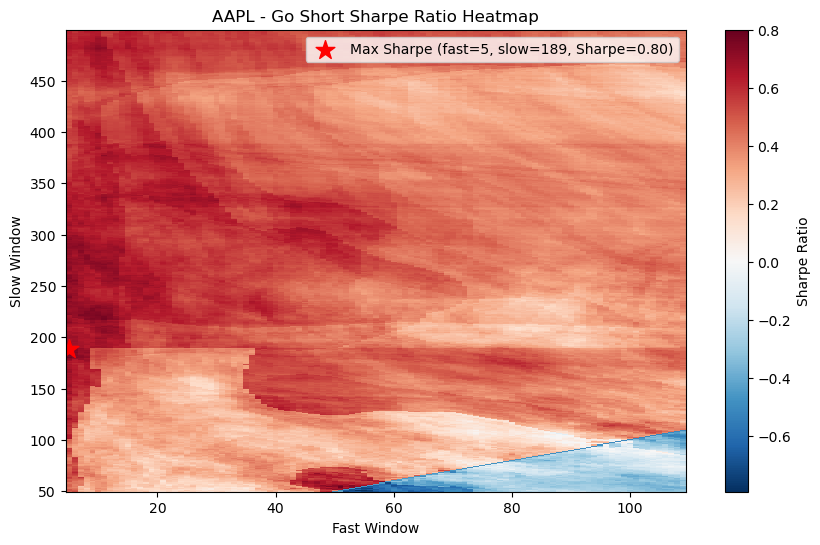

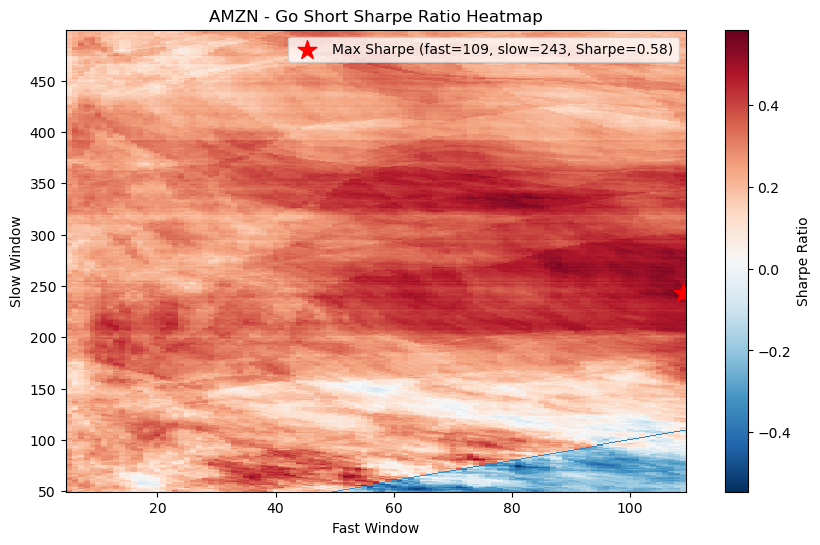

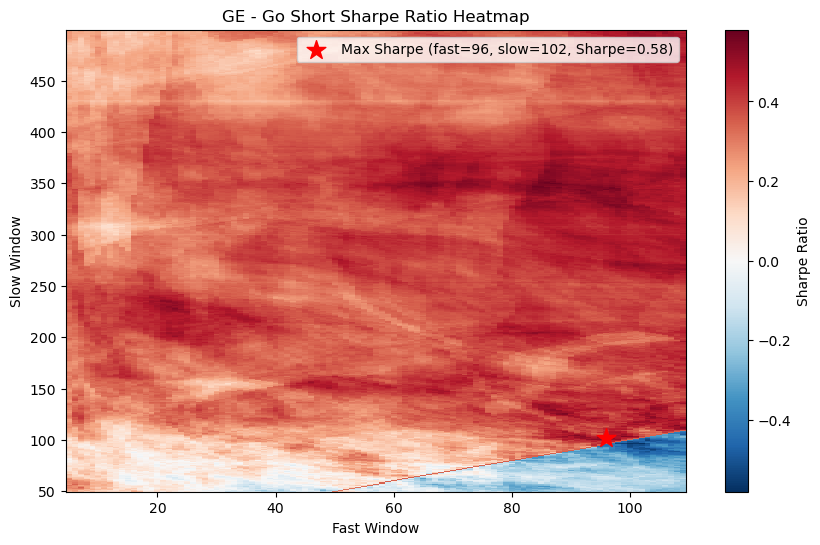

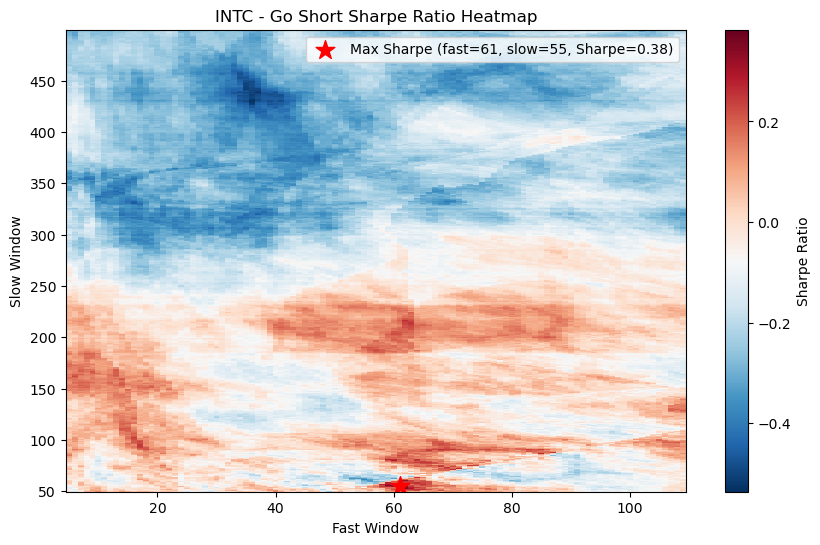

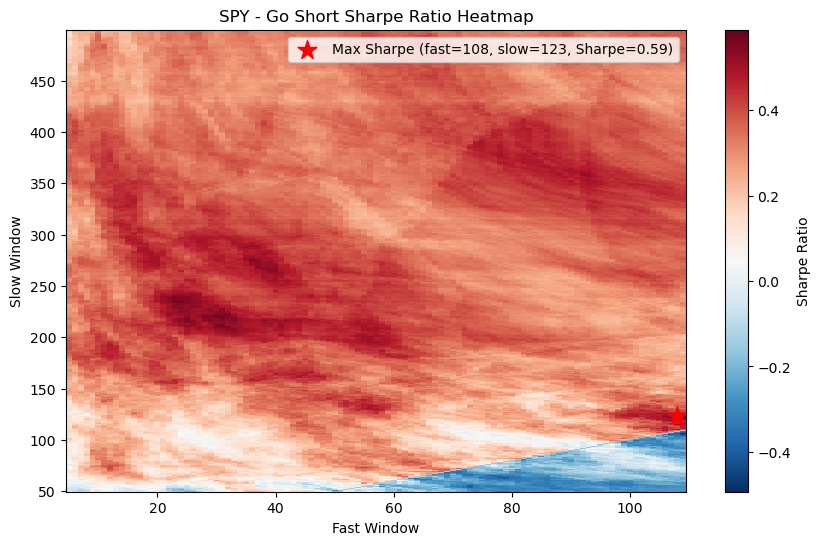

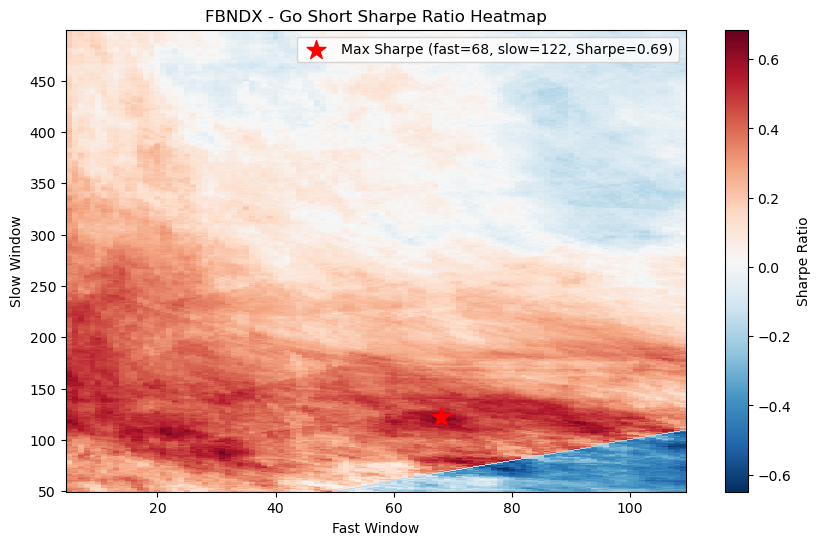

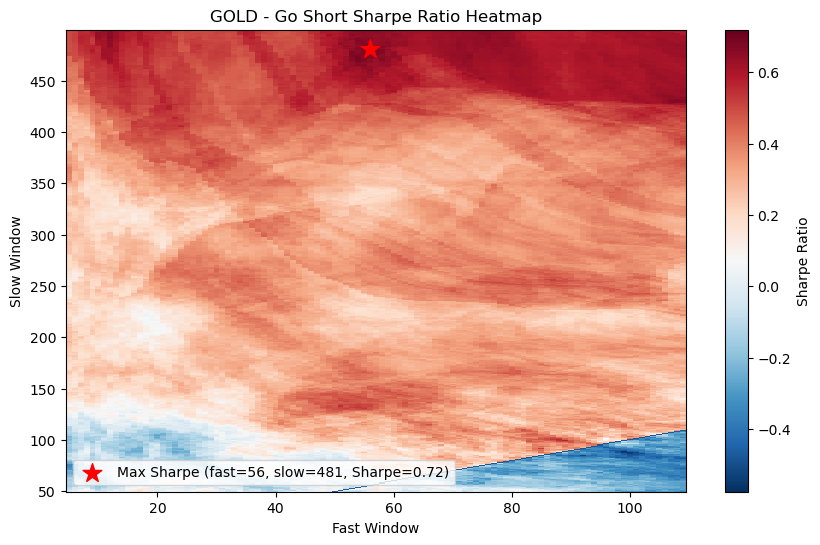

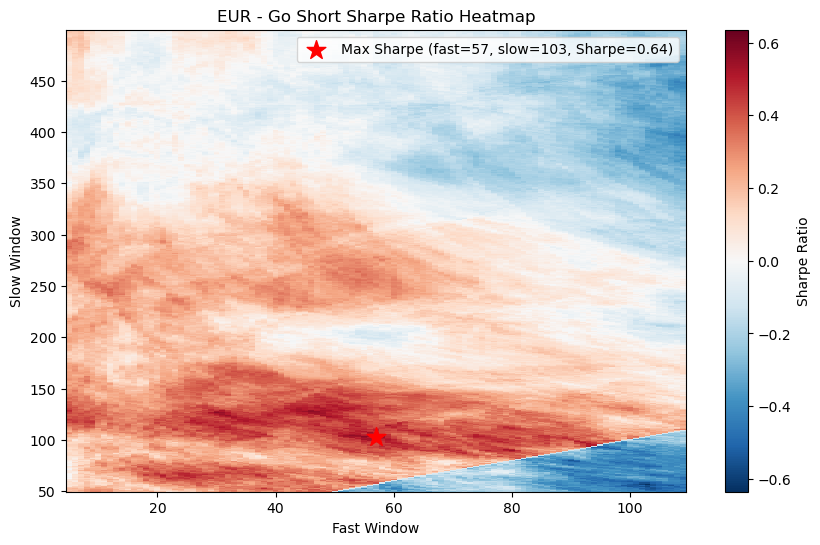

In [14]:
# Now plot the heatmaps for "Go Short" strategy
for instrument, sharpe_data in results.items():
    # Extract unique fast and slow windows
    fast_windows = np.unique(sharpe_data[0]['fastWindow'])
    slow_windows = np.unique(sharpe_data[0]['slowWindow'])

    # Reshape the Go Short Sharpe ratios into a grid for plotting
    sharpe_matrix_short = sharpe_data[0].pivot(index='slowWindow', columns='fastWindow', values='GoShortSharpe').values

    # Find the best Sharpe ratio for the "Go Short" strategy
    best_sharpe_idx_short = np.nanargmax(sharpe_matrix_short)
    best_slow_idx_short, best_fast_idx_short = np.unravel_index(best_sharpe_idx_short, sharpe_matrix_short.shape)
    best_fast_window_short = fast_windows[best_fast_idx_short]
    best_slow_window_short = slow_windows[best_slow_idx_short]
    best_sharpe_short = sharpe_matrix_short[best_slow_idx_short, best_fast_idx_short]

    # Create the heatmap plot for the Go Short Sharpe ratio
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(fast_windows, slow_windows, sharpe_matrix_short, shading='auto', cmap='RdBu_r')
    plt.colorbar(label='Sharpe Ratio')

    # Mark the maximum Sharpe point with a red star
    plt.scatter(best_fast_window_short, best_slow_window_short, color='red', marker='*', s=200,
                label=f'Max Sharpe (fast={best_fast_window_short}, slow={best_slow_window_short}, Sharpe={best_sharpe_short:.2f})')

    # Add labels and title
    plt.xlabel('Fast Window')
    plt.ylabel('Slow Window')
    plt.title(f'{instrument} - Go Short Sharpe Ratio Heatmap')
    plt.legend()

    # Show the plot
    plt.show()

#### Plotting Bollinger Band Graphs

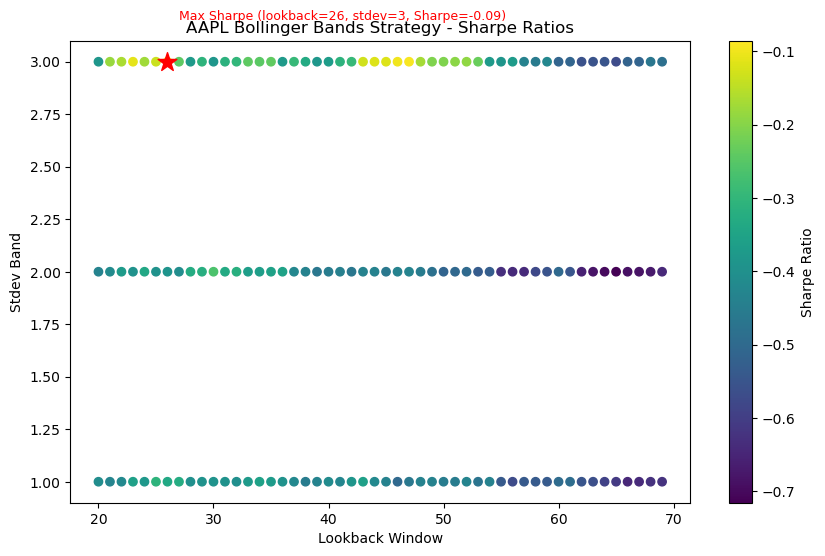

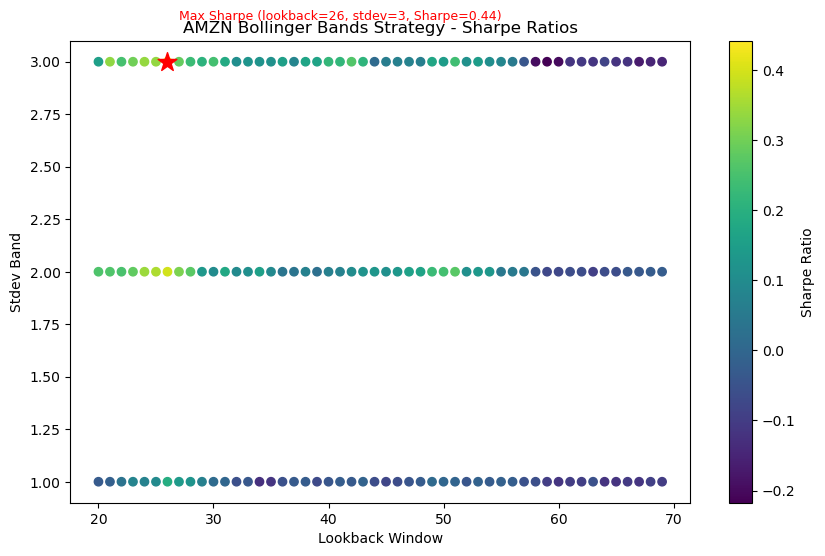

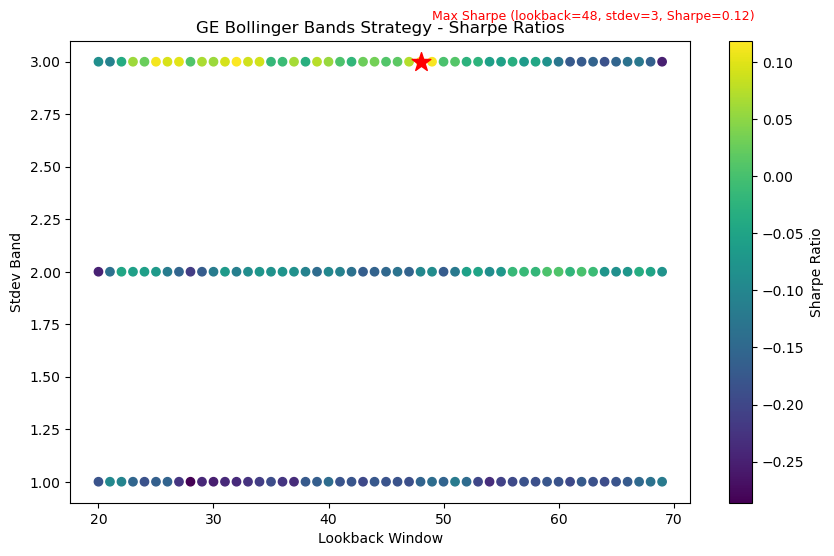

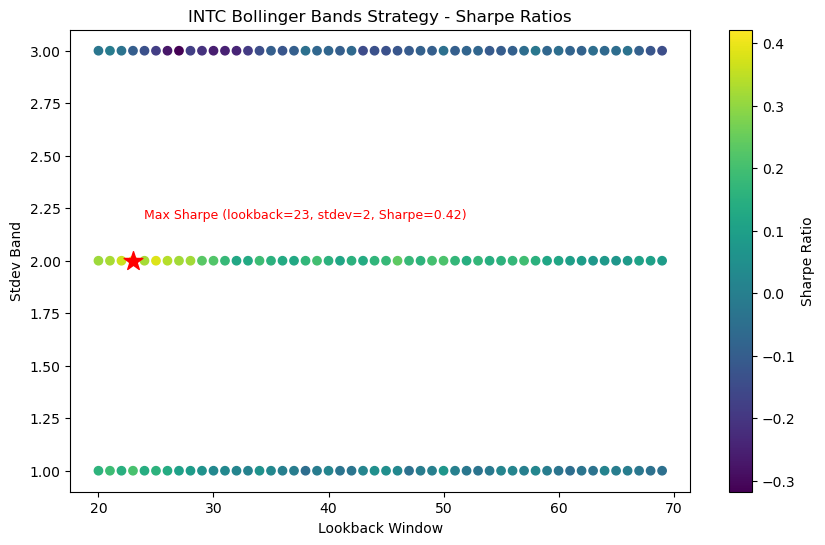

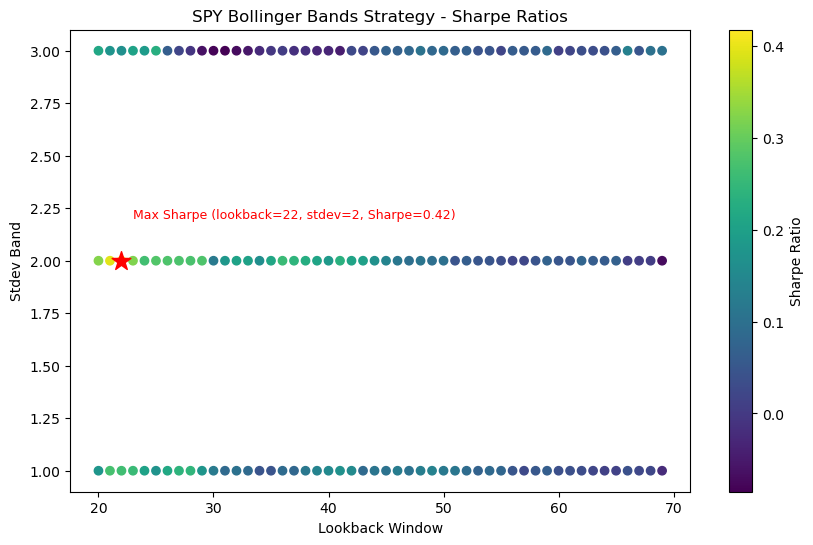

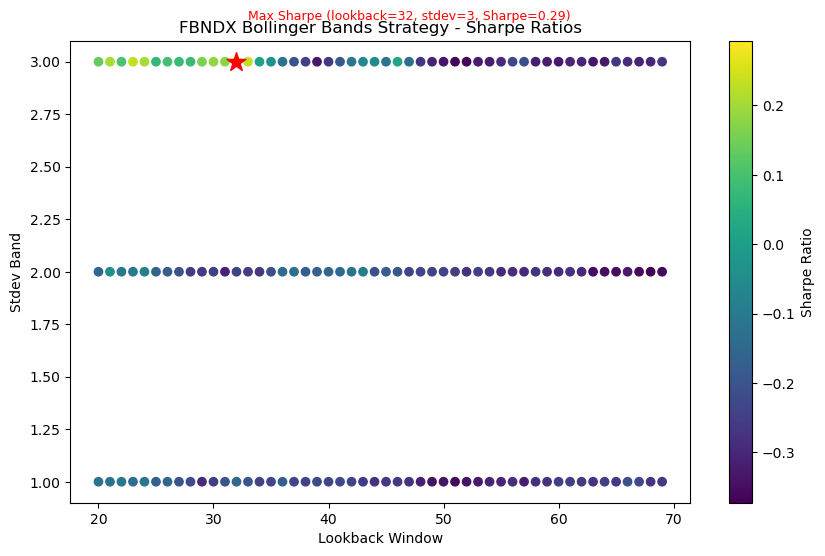

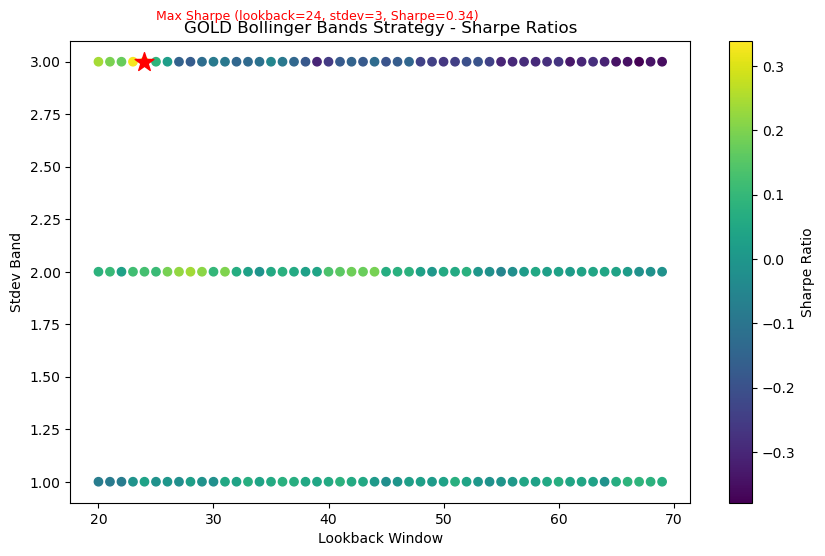

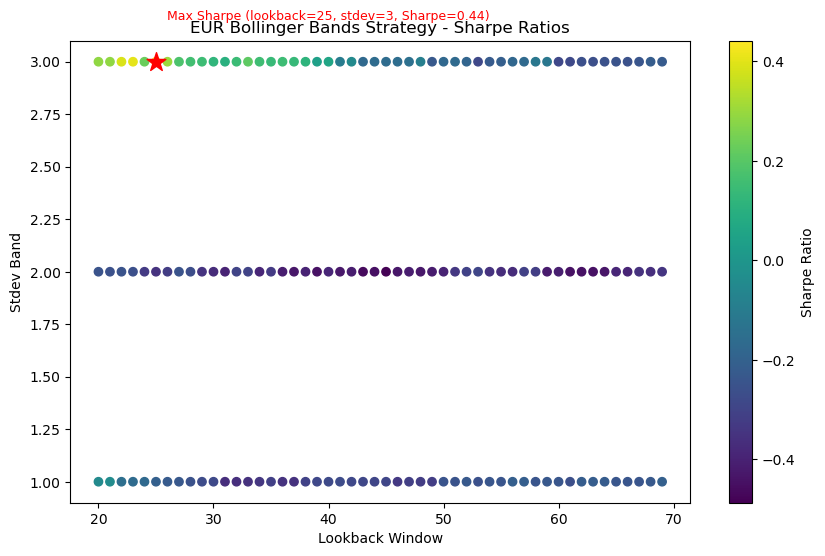

In [15]:
# Now plot the heatmaps for "BB" strategy
for instrument, sharpe_data in results.items():
    # Extract lookbackWindow, stdevBand, and Sharpe ratios from the DataFrame
    lookback_windows = sharpe_data[1]['lookbackWindow']
    stdev_bands = sharpe_data[1]['stdevBand']
    sharpe_ratios = sharpe_data[1]['BBSharpe']

    # Find the best Sharpe ratio point
    best_sharpe_idx = np.nanargmax(sharpe_ratios)
    best_lookback_window = lookback_windows[best_sharpe_idx]
    best_stdev_band = stdev_bands[best_sharpe_idx]
    best_sharpe = sharpe_ratios[best_sharpe_idx]

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(lookback_windows, stdev_bands, c=sharpe_ratios, cmap='viridis')
    plt.colorbar(scatter, label='Sharpe Ratio')

    # Mark the maximum Sharpe ratio point with a red star
    plt.scatter(best_lookback_window, best_stdev_band, color='red', marker='*', s=200)
    plt.text(best_lookback_window + 1, best_stdev_band + 0.20,
             f'Max Sharpe (lookback={best_lookback_window}, stdev={best_stdev_band}, Sharpe={best_sharpe:.2f})',
             fontsize=9, color='red')

    # Add labels and title
    plt.xlabel('Lookback Window')
    plt.ylabel('Stdev Band')
    plt.title(f'{instrument} Bollinger Bands Strategy - Sharpe Ratios')

    # Show the plot
    plt.show()

## Q5 Parameter and Strategy Selection

#### For the construction of our portfolio, the following parameters and strategies have been chosen for the moving average and Bollinger Band strategies:

* ### Moving Average Fast Window: 11

* ### Moving Average Slow Window: 220

* ### Bollinger Band Lookback Window: 23

* ### Bollinger Band Standard Deviation Band: 2


#### The selected instruments and their corresponding strategies (in alphabetical order) are:

* ### AAPL (Apple): Moving Average Flat (AAPL-MAFlat)
* ### AMZN (Amazon): Moving Average Flat (AMZN-MAFlat)
* ### EUR (Euro): Moving Average Short (EUR-MAShort)
* ### GE (General Electric): Moving Average Short (GE-MAShort)
* ### GOLD (Gold): Moving Average Flat (GOLD-MAFlat)
* ### INTC (Intel): Bollinger Band (INTC-BB)
* ### FBNDX (Fidelity Investment Grade Bond Index): Moving Average Short (FBNDX-MAShort)
* ### SPY (S&P 500 ETF): Moving Average Flat (SPY-MAFlat)

## Q6. Running the runMovingAverageAndBB Function and Creating the Master DataFrame

In [52]:
# List of all 12 instruments
instruments = ['AAPL', 'AMZN', 'ATT', 'GE', 'INTC', 'SPY',  # Equities
               'FBNDX', 'LEHM',  # Fixed Income
               'GOLD', 'SILVER',  # Commodities
               'AUD', 'EUR']  # Currencies

# Define the parameters based on your chosen values
fastWindow = 11
slowWindow = 220
bbWindow = 23
stdevBand = 2

# Initialize an empty list to store the DataFrames for each instrument
dfs = []

# Loop through each instrument and apply the strategies
for instrument in instruments:
    print(f"Processing {instrument}...")

    # Select only the instrument's price data
    data = dfPrices[[instrument]].dropna()

    # Run the combined Moving Average and Bollinger Band strategy
    result = runMovingAverageAndBB(data, fastWindow, slowWindow, bbWindow, stdevBand)

    # Rename the columns to include the instrument name for uniqueness in the master DataFrame
    # result = result.add_prefix(f"{instrument}-")

    # Append the result to the list of DataFrames
    dfs.append(result)

# Concatenate all the individual DataFrames along the columns (axis=1)
master_df = pd.concat(dfs, axis=1)

# Display the master DataFrame
print(master_df.head())

# Verify the shape (should be rows × 60 columns)
print(f"Master DataFrame Shape: {master_df.shape}")

# Optional: Save the master DataFrame to a CSV for further analysis
master_df.to_csv('master_dataframe.csv', index=True)


Processing AAPL...
Processing AMZN...
Processing ATT...
Processing GE...
Processing INTC...
Processing SPY...
Processing FBNDX...
Processing LEHM...
Processing GOLD...
Processing SILVER...
Processing AUD...
Processing EUR...
            AAPL-BMK-MA  AAPL-MAFlat  AAPL-MAShort  AAPL-BMK-BB  AAPL-BB  \
2000-11-14     0.044171          0.0     -0.044171     0.044171      0.0   
2000-11-15    -0.018691         -0.0      0.018691    -0.018691     -0.0   
2000-11-16    -0.045024         -0.0      0.045024    -0.045024     -0.0   
2000-11-17    -0.026670         -0.0      0.026670    -0.026670     -0.0   
2000-11-20     0.023375          0.0     -0.023375     0.023375      0.0   

            AMZN-BMK-MA  AMZN-MAFlat  AMZN-MAShort  AMZN-BMK-BB  AMZN-BB  ...  \
2000-11-14     0.039653          0.0     -0.039653     0.039653      0.0  ...   
2000-11-15     0.019252          0.0     -0.019252     0.019252      0.0  ...   
2000-11-16    -0.058905         -0.0      0.058905    -0.058905     -0.0  .

## Q7. Portfolio Strategy Rationale and Sharpe Optimization

### Rationale for Portfolio Choices
#### The goal of constructing this portfolio was to achieve a Sharpe ratio greater than 1.0 by selecting instruments and strategies that provided a good balance between risk and return. Our selection process aimed not only to choose high-performing instruments but also to combine strategies that were not highly correlated, thereby benefiting from diversification.


### Parameter Selection

#### After running scatter plots for each strategy on the selected instruments (AAPL, AMZN, GE, INTC, SPY, FBNDX, GOLD, EUR), we identified the following parameters to provide the best trade-off between risk and reward:

* #### Moving Average Parameters:  Fast Window = 11, Slow Window = 220


* #### Bollinger Bands Parameters: Lookback Window = 23, Standard Deviation Band = 2


### Why These Parameters?

1. #### Go Flat Strategy:
AAPL, AMZN, GOLD and SPY were selected because they provided one of the highest Sharpe ratios in their respective analyses.

    AAPL: 1.029

    AMZN: 0.808
    
    GOLD: 0.689
    
    SPY: 0.660

The chosen window sizes (Fast = 11, Slow = 220) allowed us to capture short-term momentum while still considering longer-term trends, effectively reducing false signals and improving overall portfolio performance.

2. #### Go Short Strategy:
GE, FBNDX, and EUR were selected because they performed well under shorting conditions, contributing to the portfolio's ability to hedge against market downturns.

    GE: 0.580

    EUR: 0.635
    
    FBNDX: 0.685

The shorting strategy provided negative correlation with other instruments, further enhancing the portfolio’s risk management through diversification.

3. #### Bollinger Bands Strategy:
INTC, was selected for Bollinger Bands due to their reasonably high Sharpe ratios, making them suitable candidates for volatility-based strategies.

    INTC: 0.422


The lookback window of 23 and standard deviation band of 2 were chosen to provide a more sensitive reaction to price changes, allowing for timely buy and sell signals.


### Importance of Correlation

In summary, the choice of fast and slow windows (11 and 220) and Bollinger Band parameters were driven by the need to balance short-term reactivity with long-term trends, ensuring consistent performance across the portfolio. The combination of high Sharpe ratio instruments and taking windows beneficial to them whereas diversification through non-correlated assets helped achieve our goal of optimizing risk-adjusted returns.

## Q8. Creating a Subset of Daily Returns for Chosen Strategies

In [53]:
# Define the 8 chosen strategies in alphabetical order
myStrategies = [
    'AAPL-MAFlat', 'AMZN-MAFlat', 'EUR-MAShort',
    'FBNDX-MAShort', 'GE-MAShort', 'GOLD-MAFlat',
    'INTC-BB', 'SPY-MAFlat'
]

# Create the 'myStrategies' DataFrame by subsetting the master DataFrame
myStrategies_df = master_df[[f"{strategy}" for strategy in myStrategies]].copy()

# Display the first few rows to confirm the subset
print(myStrategies_df.head())

# Verify the shape of the new DataFrame
print(f"My Strategies DataFrame Shape: {myStrategies_df.shape}")

# Optional: Save to a CSV file for later use
myStrategies_df.to_csv('myStrategies_dataframe.csv', index=True)


            AAPL-MAFlat  AMZN-MAFlat  EUR-MAShort  FBNDX-MAShort  GE-MAShort  \
2000-11-14          0.0          0.0    -0.000583       0.001428    0.025196   
2000-11-15         -0.0          0.0     0.000117       0.001426   -0.004751   
2000-11-16         -0.0         -0.0     0.005027       0.001423    0.002378   
2000-11-17         -0.0         -0.0     0.006349      -0.001423   -0.014354   
2000-11-20          0.0         -0.0    -0.004237       0.000000   -0.035565   

            GOLD-MAFlat  INTC-BB  SPY-MAFlat  
2000-11-14          0.0      0.0         0.0  
2000-11-15          0.0      0.0         0.0  
2000-11-16          0.0     -0.0        -0.0  
2000-11-17         -0.0      0.0        -0.0  
2000-11-20          0.0     -0.0        -0.0  
My Strategies DataFrame Shape: (4525, 8)


## Q9. Correlation Structure

Correlation Matrix for myStrategies:
               AAPL-MAFlat  AMZN-MAFlat  EUR-MAShort  FBNDX-MAShort  \
AAPL-MAFlat       1.000000     0.257187    -0.003289       0.009230   
AMZN-MAFlat       0.257187     1.000000    -0.010962      -0.042437   
EUR-MAShort      -0.003289    -0.010962     1.000000       0.032295   
FBNDX-MAShort     0.009230    -0.042437     0.032295       1.000000   
GE-MAShort       -0.020063    -0.049674     0.121075       0.019052   
GOLD-MAFlat       0.007899    -0.021143     0.210618       0.022128   
INTC-BB           0.033121     0.055498    -0.018480       0.010636   
SPY-MAFlat        0.389896     0.324199     0.045526      -0.082354   

               GE-MAShort  GOLD-MAFlat   INTC-BB  SPY-MAFlat  
AAPL-MAFlat     -0.020063     0.007899  0.033121    0.389896  
AMZN-MAFlat     -0.049674    -0.021143  0.055498    0.324199  
EUR-MAShort      0.121075     0.210618 -0.018480    0.045526  
FBNDX-MAShort    0.019052     0.022128  0.010636   -0.082354  
GE-MASho

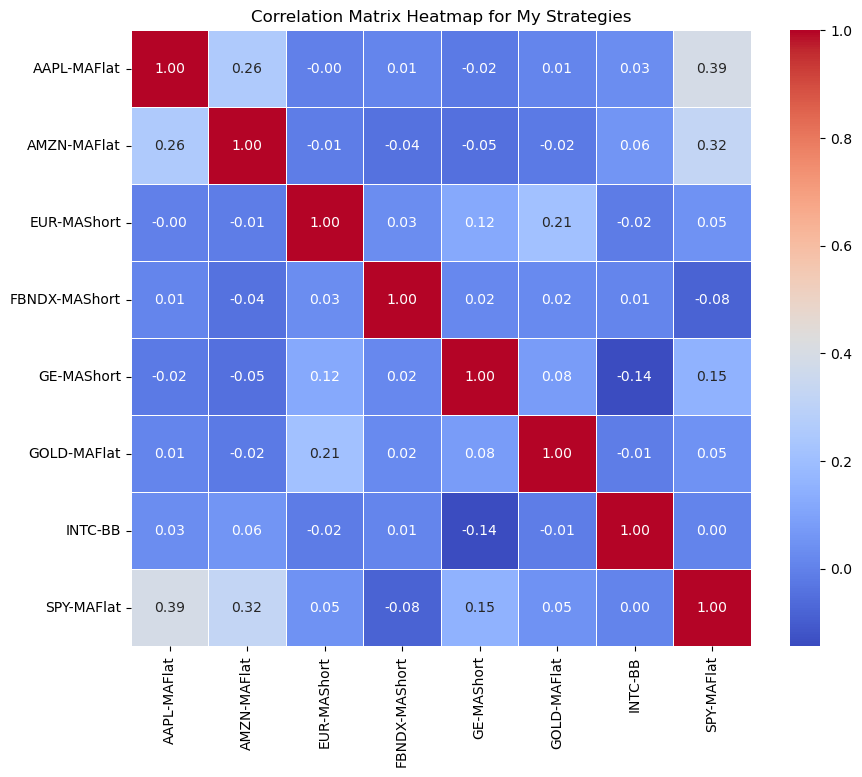

In [54]:
# Calculate the correlation matrix for the 'myStrategies' DataFrame
correlation_matrix = myStrategies_df.corr()

# Display the correlation matrix
print("Correlation Matrix for myStrategies:")
print(correlation_matrix)
print("\n")

# Optional: Plot the heatmap for the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap for My Strategies')
plt.show()

### The correlation matrix shows:

* #### Positive Correlations:
AAPL-MAFlat and SPY-MAFlat (0.39): Moderate correlation due to both being equity related instruments.
    
    SPY-MAFlat and AMZN-MAFlat (0.32): Moderate correlation due to both being equity related instruments.

* #### Negative Correlations:
INTC-BB and GE-MAShort (-0.14): Indicates GE’s short strategy tends to move opposite to INTC's bollinger band strategy.

* #### Low Correlations:
SPY-MAFlat and INTC-BB (0.00): No relationship, adding diversification.
    
    GOLD-MAFlat and INTC-BB (-0.01): Almost no relationship, adding diversification.
    
    GOLD-MAFlat and AAPL-MAFlat (0.01): Almost no relationship, adding diversification.


This shows that equities are more correlated and the bonds, gold and currency provide more diversification.  <br>

Negative correlation for GE’s short strategy with INTC's bollinger band strategy, may help hedge risks and improve portfolio stability.


## Q10. Sharpe Ratio Analysis of an Equal-Weight Portfolio

In [55]:
import numpy as np

# Step 1: Calculate the equal-weighted portfolio returns
equal_weight_returns = myStrategies_df.mean(axis=1)  # Average across all strategies for each day

# Step 2: Define the Sharpe ratio calculation function
def calculate_sharpe(returns, annualization_factor=260):
    return (returns.mean() / returns.std()) * np.sqrt(annualization_factor)

# Step 3: Calculate the annualized Sharpe ratio of the portfolio
portfolio_sharpe = calculate_sharpe(equal_weight_returns)

# Step 4: Calculate individual Sharpe ratios for each strategy
individual_sharpes = myStrategies_df.apply(calculate_sharpe)

# Step 5: Check if the portfolio Sharpe exceeds every individual strategy's Sharpe
outperforms_all = portfolio_sharpe > individual_sharpes.max()

# Display Results
print(f"Equal-Weighted Portfolio Sharpe Ratio: {portfolio_sharpe:.3f}")
print(f"Does the portfolio Sharpe outperform all individual strategies? {outperforms_all}")

# Optional: Print individual Sharpe ratios for reference
print("\nIndividual Strategy Sharpes:")
print(individual_sharpes)

Equal-Weighted Portfolio Sharpe Ratio: 1.285
Does the portfolio Sharpe outperform all individual strategies? True

Individual Strategy Sharpes:
AAPL-MAFlat      1.018386
AMZN-MAFlat      0.663359
EUR-MAShort      0.243639
FBNDX-MAShort    0.404243
GE-MAShort       0.404015
GOLD-MAFlat      0.439929
INTC-BB          0.442973
SPY-MAFlat       0.543493
dtype: float64


#### Yes, the Equal-Weighted Portfolio outperforms all the individual instrument strategies. It gives a Sharpe-Ratio of 1.285 which is easily above the highest Sharpe-Ratio instrument i.e AAPL-MAFlat

## Q11. Mean-Variance Optimization for Optimal Portfolio Weights

In [56]:
import numpy as np
import pandas as pd

# Set the seed for reproducibility
rng = np.random.default_rng(seed=64)

# Number of simulations
n_simulations = 5000

# Calculate the mean returns and covariance matrix for the 8 chosen strategies
mean_returns = myStrategies_df.mean()
cov_matrix = myStrategies_df.cov()

# Arrays to store simulation results
portfolio_returns = np.zeros(n_simulations)
portfolio_risks = np.zeros(n_simulations)
portfolio_weights = np.zeros((n_simulations, myStrategies_df.shape[1]))
weights_record = []

# Annualization factor (260 trading days)
annualization_factor = 260

# Monte Carlo simulation to generate portfolios
for i in range(n_simulations):
    # Generate random weights and normalize them
    weights = rng.random(myStrategies_df.shape[1])
    weights /= np.sum(weights)
    weights_record.append(weights)

    # Calculate portfolio return and risk
    portfolio_return = np.sum(mean_returns * weights) * annualization_factor
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(annualization_factor)

    # Store results
    portfolio_returns[i] = portfolio_return
    portfolio_risks[i] = portfolio_risk
    portfolio_weights[i, :] = weights

# Calculate Sharpe ratios
sharpe_ratios = portfolio_returns / portfolio_risks

# Find the index of the minimum volatility and maximum Sharpe ratio portfolios
min_vol_index = np.argmin(portfolio_risks)
max_sharpe_index = np.argmax(sharpe_ratios)

# Extract the corresponding weight vectors
min_vol_weights = weights_record[min_vol_index]
max_sharpe_weights = weights_record[max_sharpe_index]

# Create a DataFrame for Min Vol and Max Sharpe weights
df_weights = pd.DataFrame({
    'Min Vol': min_vol_weights,
    'Max Sharpe': max_sharpe_weights
}, index=myStrategies_df.columns)

# Display the results in percentage format
print("Optimal Weights for Min Vol and Max Sharpe Portfolios:")
print(df_weights.applymap(lambda x: f'{x:.2%}'))


Optimal Weights for Min Vol and Max Sharpe Portfolios:
              Min Vol Max Sharpe
AAPL-MAFlat     0.86%     19.40%
AMZN-MAFlat     5.12%      7.87%
EUR-MAShort    17.06%     15.72%
FBNDX-MAShort  35.90%     21.12%
GE-MAShort      0.83%      9.01%
GOLD-MAFlat    13.50%     12.39%
INTC-BB         0.16%      7.98%
SPY-MAFlat     26.57%      6.52%


## Q12 - Q14  Plotting Risk/Return Scatter Chart and Identifying Optimal Portfolios

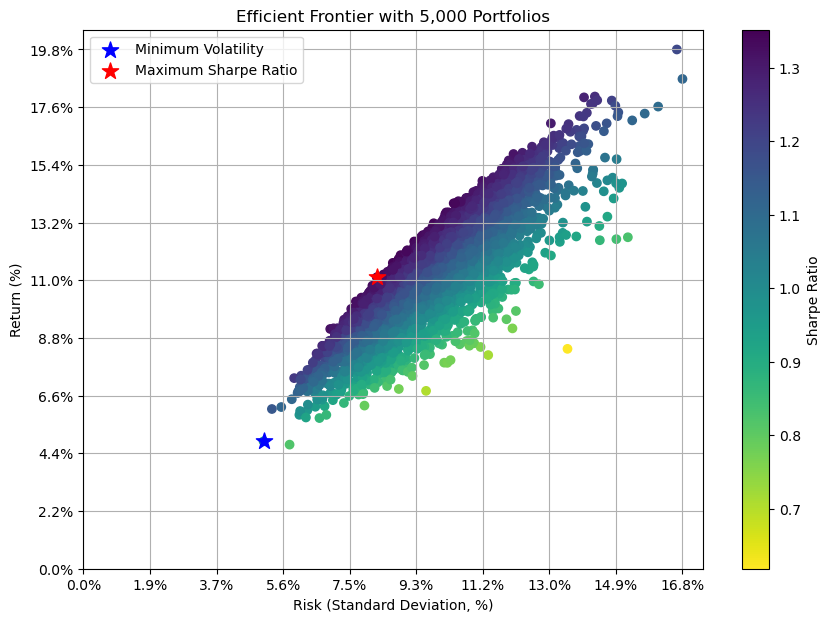

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Generate the plot for all 5,000 portfolios
min_vol_index = np.argmin(portfolio_risks)  # Index of the minimum volatility portfolio
max_sharpe_index = np.argmax(sharpe_ratios)  # Index of the maximum Sharpe ratio portfolio

plt.figure(figsize=(10, 7))

# Scatter plot of all portfolios with color based on Sharpe ratio
sc = plt.scatter(portfolio_risks, portfolio_returns, c=sharpe_ratios, cmap='viridis_r', marker='o')

# Add colorbar for the Sharpe ratio
plt.colorbar(sc, label='Sharpe Ratio')

# Highlight the minimum volatility portfolio with a blue star
plt.scatter(portfolio_risks[min_vol_index], portfolio_returns[min_vol_index],
            color='blue', marker='*', s=150, label='Minimum Volatility')

# Highlight the maximum Sharpe ratio portfolio with a red star
plt.scatter(portfolio_risks[max_sharpe_index], portfolio_returns[max_sharpe_index],
            color='red', marker='*', s=150, label='Maximum Sharpe Ratio')

# Set plot title and labels
plt.title('Efficient Frontier with 5,000 Portfolios')
plt.xlabel('Risk (Standard Deviation, %)')
plt.ylabel('Return (%)')

# Format x-axis and y-axis as percentages
plt.xticks(ticks=np.linspace(0, np.max(portfolio_risks), 10),
           labels=[f'{x * 100:.1f}%' for x in np.linspace(0, np.max(portfolio_risks), 10)])
plt.yticks(ticks=np.linspace(0, np.max(portfolio_returns), 10),
           labels=[f'{y * 100:.1f}%' for y in np.linspace(0, np.max(portfolio_returns), 10)])

# Add legend and grid
plt.legend(loc='best', frameon=True)
plt.grid(True)

# Show the plot
plt.show()


Weights of the Minimum Volatility Portfolio:
                 Weight
AAPL-MAFlat    0.008611
AMZN-MAFlat    0.051194
EUR-MAShort    0.170568
FBNDX-MAShort  0.358971
GE-MAShort     0.008286
GOLD-MAFlat    0.135006
INTC-BB        0.001624
SPY-MAFlat     0.265740



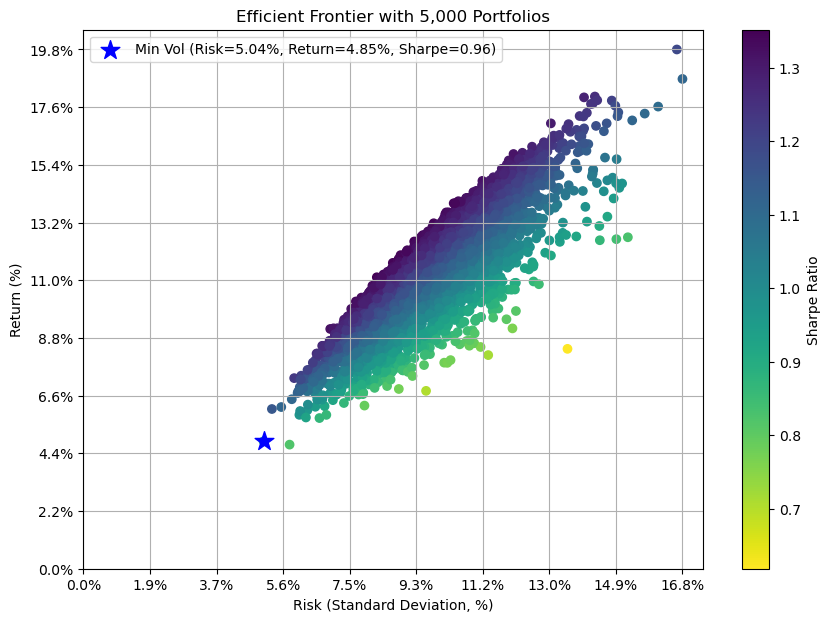

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Generate the index of the minimum volatility portfolio
min_vol_index = np.argmin(portfolio_risks)

# Extract the corresponding weights, risk, return, and Sharpe ratio for the minimum volatility portfolio
min_vol_weights = portfolio_weights[min_vol_index]
min_vol_risk = portfolio_risks[min_vol_index]
min_vol_return = portfolio_returns[min_vol_index]
min_vol_sharpe = sharpe_ratios[min_vol_index]

# Create DataFrame to display the weights of the minimum volatility portfolio
min_vol_weights_df = pd.DataFrame(min_vol_weights, index=myStrategies, columns=['Weight'])

# Print the weights of the minimum volatility portfolio
print("Weights of the Minimum Volatility Portfolio:")
print(min_vol_weights_df)
print("")

# Plot the Efficient Frontier with Minimum Volatility Portfolio
plt.figure(figsize=(10, 7))

# Scatter plot of all portfolios with color based on Sharpe ratio
sc = plt.scatter(portfolio_risks, portfolio_returns, c=sharpe_ratios, cmap='viridis_r', marker='o')

# Add colorbar for Sharpe ratio
plt.colorbar(sc, label='Sharpe Ratio')

# Highlight the minimum volatility portfolio with a blue star
plt.scatter(min_vol_risk, min_vol_return, color='blue', marker='*', s=200,
            label=f'Min Vol (Risk={min_vol_risk*100:.2f}%, Return={min_vol_return*100:.2f}%, Sharpe={min_vol_sharpe:.2f})')

# Set plot title and labels
plt.title('Efficient Frontier with 5,000 Portfolios')
plt.xlabel('Risk (Standard Deviation, %)')
plt.ylabel('Return (%)')

# Format x-axis and y-axis as percentages
plt.xticks(ticks=np.linspace(0, np.max(portfolio_risks), 10),
           labels=[f'{x * 100:.1f}%' for x in np.linspace(0, np.max(portfolio_risks), 10)])
plt.yticks(ticks=np.linspace(0, np.max(portfolio_returns), 10),
           labels=[f'{y * 100:.1f}%' for y in np.linspace(0, np.max(portfolio_returns), 10)])

# Add legend and grid
plt.legend(loc='best', frameon=True)
plt.grid(True)

# Show the plot
plt.show()

Weights of the Maximum Sharpe Portfolio:
                 Weight
AAPL-MAFlat    0.194026
AMZN-MAFlat    0.078658
EUR-MAShort    0.157184
FBNDX-MAShort  0.211177
GE-MAShort     0.090113
GOLD-MAFlat    0.123886
INTC-BB        0.079779
SPY-MAFlat     0.065178



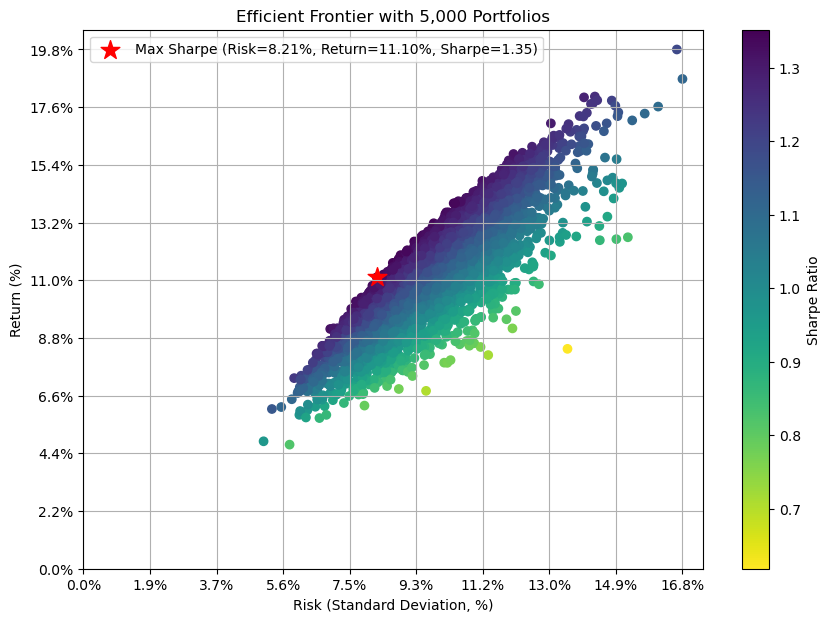

In [59]:
# Generate the index of the maximum Sharpe ratio portfolio
max_sharpe_index = np.argmax(sharpe_ratios)

# Extract the corresponding weights, risk, return, and Sharpe ratio for the maximum Sharpe portfolio
max_sharpe_weights = portfolio_weights[max_sharpe_index]
max_sharpe_risk = portfolio_risks[max_sharpe_index]
max_sharpe_return = portfolio_returns[max_sharpe_index]
max_sharpe = sharpe_ratios[max_sharpe_index]

# Create DataFrame to display the weights of the maximum Sharpe portfolio
max_sharpe_weights_df = pd.DataFrame(max_sharpe_weights, index=myStrategies, columns=['Weight'])

# Print the weights of the maximum Sharpe portfolio
print("Weights of the Maximum Sharpe Portfolio:")
print(max_sharpe_weights_df)
print("")

# Plot the Efficient Frontier with Maximum Sharpe Portfolio
plt.figure(figsize=(10, 7))

# Scatter plot of all portfolios with color based on Sharpe ratio
sc = plt.scatter(portfolio_risks, portfolio_returns, c=sharpe_ratios, cmap='viridis_r', marker='o')

# Add colorbar for Sharpe ratio
plt.colorbar(sc, label='Sharpe Ratio')

# Highlight the maximum Sharpe portfolio with a red star
plt.scatter(max_sharpe_risk, max_sharpe_return, color='red', marker='*', s=200,
            label=f'Max Sharpe (Risk={max_sharpe_risk*100:.2f}%, Return={max_sharpe_return*100:.2f}%, Sharpe={max_sharpe:.2f})')

# Set plot title and labels
plt.title('Efficient Frontier with 5,000 Portfolios')
plt.xlabel('Risk (Standard Deviation, %)')
plt.ylabel('Return (%)')

# Format x-axis and y-axis as percentages
plt.xticks(ticks=np.linspace(0, np.max(portfolio_risks), 10),
           labels=[f'{x * 100:.1f}%' for x in np.linspace(0, np.max(portfolio_risks), 10)])
plt.yticks(ticks=np.linspace(0, np.max(portfolio_returns), 10),
           labels=[f'{y * 100:.1f}%' for y in np.linspace(0, np.max(portfolio_returns), 10)])

# Add legend and grid
plt.legend(loc='best', frameon=True)
plt.grid(True)

# Show the plot
plt.show()


## Q15.

#### Yes, the maximum Sharpe is higher than the equal weight Sharpe from #10 above.

## Q16. Adding Maximum Sharpe Portfolio and Analyzing Performance

In [60]:
# Calculate MAX-Sharpe Portfolio and add it to "My Strategies" portfolio.
weights = max_sharpe_weights
max_sharpe_df = pd.DataFrame((weights * myStrategies_df).sum(axis=1, skipna=False), columns=['Max Sharpe Portfolio'])
myStrategies_df = myStrategies_df.join(max_sharpe_df, how='inner')

In [61]:
# Calculate Performance Statistics
calcPerformanceStatistics(myStrategies_df)

Performance Statistics:


AAPL-MAFlat  AMZN-MAFlat  EUR-MAShort  FBNDX-MAShort  \
Average Annual Return     0.279595     0.219618     0.024583       0.015420   
Annual Risk               0.274548     0.331070     0.100898       0.038145   
Sharpe Ratio              1.018386     0.663359     0.243639       0.404243   
Max Drawdown             -0.560454    -0.547177    -0.287990      -0.126006   
Success Ratio             0.659006     0.668729     0.515580       0.642431   

                       GE-MAShort  GOLD-MAFlat   INTC-BB  SPY-MAFlat  \
Average Annual Return    0.125548     0.063500  0.118114    0.057765   
Annual Risk              0.310752     0.144342  0.266639    0.106285   
Sharpe Ratio             0.404015     0.439929  0.442973    0.543493   
Max Drawdown            -0.906678    -0.395251 -0.503874   -0.194994   
Success Ratio            0.518232     0.683978  0.738343    0.695691   

                       Max Sharpe Portfolio  
Average Annual Return              0.111012  
Annual Risk                        0.082109  
Sharpe Ratio                       1.352016  
Max Drawdown                      -0.124966  
Success Ratio                      0.548508

### Salient Features (of Max-Sharpe Portfolio):
#### The final portfolio, as optimized by the Sharpe ratio, provides a better risk-adjusted return than any individual strategy, with a lower risk and drawdown. While the average annual return is not the highest, the portfolio's Sharpe ratio (1.35) and lower risk make it a strong candidate for risk-averse investors looking for consistent performance with minimal losses. The portfolio achieves a balance between return and risk, making it more efficient than holding any individual component.

## Q17. Beta Calculation of Maximum Sharpe Portfolio against S&P 500

In [62]:
# Calculate Beta by doing Regression for Max-Sharpe Portfolio against S@P 500
max_sharpe_port_Reg = sm.OLS(myStrategies_df.dropna()['Max Sharpe Portfolio'], sm.add_constant(master_df.dropna()['SPY-BMK-MA'])).fit()
print(max_sharpe_port_Reg.summary())

                             OLS Regression Results                             
Dep. Variable:     Max Sharpe Portfolio   R-squared:                       0.071
Model:                              OLS   Adj. R-squared:                  0.071
Method:                   Least Squares   F-statistic:                     344.8
Date:                  Sun, 20 Oct 2024   Prob (F-statistic):           3.13e-74
Time:                          11:28:32   Log-Likelihood:                 17638.
No. Observations:                  4525   AIC:                        -3.527e+04
Df Residuals:                      4523   BIC:                        -3.526e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004    7.3e-05

In [63]:
# Fetch and display Beta value
print(f"Beta for Max Sharpe Portfolio against S&P 500: {max_sharpe_port_Reg.params['SPY-BMK-MA']}")

Beta for Max Sharpe Portfolio against S&P 500: 0.11268977524524257


### Insights based on Beta
#### The beta value of 0.1127 for the Max Sharpe Portfolio with respect to the S&P 500 indicates that the portfolio has significantly lower sensitivity to the overall market. Specifically, for every 1% move in the S&P 500, the Max Sharpe Portfolio is expected to move by only 0.1127%. This suggests that the Max Sharpe Portfolio is much less volatile than the market. A beta of less than 1 implies that the portfolio is defensive and less prone to large swings in value in response to market changes, offering some protection during periods of market downturns.

## Q18. Constructing and Comparing Variations of Equal-Weighted Portfolios

In [68]:
# Equal weights for the 12 instruments.
weights = np.ones(8)/8
instruments = ['AAPL','AMZN','GE','INTC','SPY','FBNDX','GOLD','EUR']
master_df_copy = master_df.filter(regex='|'.join([f'^{instr}' for instr in instruments]))

# a. Benchmark-only portfolio (columns ending with -BMK-MA)
bmk_df = master_df_copy.filter(like='-BMK-MA')
bmk_portfolio_returns = pd.DataFrame((weights * bmk_df).sum(axis=1, skipna=False), columns=['Benchmark Portfolio'])

# b. MAFlat strategy portfolio (columns ending with -MAFlat)
goFlat_df = master_df_copy.filter(like='-MAFlat')
goFlat_portfolio_returns = pd.DataFrame((weights * goFlat_df).sum(axis=1, skipna=False), columns=['Go Flat Portfolio'])

# c. MAShort strategy portfolio (columns ending with -MAShort)
goShort_df = master_df_copy.filter(like='-MAShort')
goShort_portfolio_returns = pd.DataFrame((weights * goShort_df).sum(axis=1, skipna=False), columns=['Go Short Portfolio'])

# d. BollingerBand strategy portfolio (columns ending with -BB)
bb_df = master_df_copy.filter(regex='^(?!.*-BMK-).*?-BB$') # Use regex to select columns that end with '-BB' but do not contain '-BMK-'
bb_portfolio_returns = pd.DataFrame((weights * bb_df).sum(axis=1, skipna=False), columns=['Bollinger Band Portfolio'])

# Calculate Sharpe ratios
sharpe_bmk = calculate_sharpe(bmk_portfolio_returns)
sharpe_goFlat = calculate_sharpe(goFlat_portfolio_returns)
sharpe_goShort = calculate_sharpe(goShort_portfolio_returns)
sharpe_bb = calculate_sharpe(bb_portfolio_returns)

# Display results
print(f"Sharpe Ratio for Equal Weighted Benchmark portfolio: {sharpe_bmk.iloc[0]:.3f}")
print(f"Sharpe Ratio for Equal Weighted MAFlat strategy portfolio: {sharpe_goFlat.iloc[0]:.3f}")
print(f"Sharpe Ratio for Equal Weighted MAShort strategy portfolio: {sharpe_goShort.iloc[0]:.3f}")
print(f"Sharpe Ratio for Equal Weighted BollingerBand strategy portfolio: {sharpe_bb.iloc[0]:.3f}")

Sharpe Ratio for Equal Weighted Benchmark portfolio: 0.418
Sharpe Ratio for Equal Weighted MAFlat strategy portfolio: 0.906
Sharpe Ratio for Equal Weighted MAShort strategy portfolio: 0.674
Sharpe Ratio for Equal Weighted BollingerBand strategy portfolio: 0.056


#### None of the Equal Weight portfolios of different strategies outperform or even get closer to the Max-Sharpe portfolio we got in #14.

## Thank You.

"We pledge on our honor that we have not given nor received any unauthorized assistance on this
assignment to/from other groups. Nor have we received any assistance from prior year students."  
-- Abhishek Shetty, Akshay Belnekar, Rachita Fatehpuria, Vaibhavi Hedaoo